# **Step 1: Data Preprocessing and Data Exploration**

## **Data preprocessing**

### **Step 0.1: Load MAVEN-ERE JSONL File**

In [ ]:
import json

# Step 0.1: Load MAVEN-ERE JSONL Files
def load_jsonl(filepath):
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line.strip()))
    return records

# File paths for the uploaded datasets
train_path = "/content/data/train.jsonl"
valid_path = "/content/data/valid.jsonl"
test_path = "/content/data/test.jsonl"

try:
    train_records_sample = load_jsonl(train_path)[:2]
    valid_records_sample = load_jsonl(valid_path)[:2]
    test_records_sample = load_jsonl(test_path)[:2]

    print("Train Sample:", train_records_sample)
    print("Valid Sample:", valid_records_sample)
    print("Test Sample:", test_records_sample)
    print("Sample Keys:", train_records_sample[0].keys())
    print("Sample lengths:",
          len(train_records_sample),
          len(valid_records_sample),
          len(test_records_sample))
except Exception as e:
    print("Error:", e)

Train Sample: [{'id': '364ed14fc610df6e25a2f446e2b2d2ab', 'title': 'Expedition of the Thousand', 'tokens': [['The', 'Expedition', 'of', 'the', 'Thousand', '(', 'Italian', '``', 'Spedizione', 'dei', 'Mille', "''", ')', 'was', 'an', 'event', 'of', 'the', 'Italian', 'Risorgimento', 'that', 'took', 'place', 'in', '1860', '.'], ['a', 'corps', 'of', 'volunteers', 'led', 'by', 'giuseppe', 'garibaldi', 'sailed', 'from', 'quarto', ',', 'near', 'genoa', '(', 'now', 'quarto', 'dei', 'mille', ')', 'and', 'landed', 'in', 'marsala', ',', 'sicily', ',', 'in', 'order', 'to', 'conquer', 'the', 'kingdom', 'of', 'the', 'two', 'sicilies', ',', 'ruled', 'by', 'the', 'house', 'of', 'bourbon-two', 'sicilies', '.'], ['The', 'project', 'was', 'an', 'ambitious', 'and', 'risky', 'venture', 'aiming', 'to', 'conquer', ',', 'with', 'a', 'thousand', 'men', ',', 'a', 'kingdom', 'with', 'a', 'larger', 'regular', 'army', 'and', 'a', 'more', 'powerful', 'navy', '.'], ['The', 'expedition', 'was', 'a', 'success', 'and', '

### **Step 0.2: Iterate Through Each Record**

In [ ]:
def iterate_records(records):
    """
    Iterate through each MAVEN-ERE record (news article),
    and print basic information for verification.
    """
    for idx, record in enumerate(records):
        print(f"\n==== Record #{idx+1} ====")
        print("ID:", record.get("id", "N/A"))
        print("Title:", record.get("title", "N/A"))

        # Sentences (raw text)
        sentences = record.get("sentences", [])
        print("First sentence:", sentences[0] if sentences else "[No sentences]")

        # Events
        events = record.get("events", [])
        print("Number of events:", len(events))
        event_types = [event['type'] for event in events]
        print("Event types:", list(set(event_types)))

        # Optional: Show details for first event
        if events:
            print("First event details:", events[0])

        # Break after a few records for brevity (remove this in production)
        if idx >= 2:
            break

# Example usage with the sample train records
iterate_records(train_records_sample)


==== Record #1 ====
ID: 364ed14fc610df6e25a2f446e2b2d2ab
Title: Expedition of the Thousand
First sentence: The Expedition of the Thousand (Italian "Spedizione dei Mille") was an event of the Italian Risorgimento that took place in 1860.
Number of events: 21
Event types: ['Control', 'Cause_to_make_progress', 'Achieve', 'Motion', 'Process_start', 'Creating', 'Conquering', 'Deciding', 'Dispersal', 'Ratification', 'Cause_to_amalgamate', 'Process_end', 'Participation', 'Bringing', 'Self_motion', 'Using', 'Aiming']
First event details: {'id': 'EVENT_e2cbbfb4a5ab65856ccc7057443120e0', 'type': 'Control', 'type_id': 41, 'mention': [{'id': 'd67d19cc8d3a9346e6dbea2a76a6d1d9', 'trigger_word': 'ruled', 'sent_id': 1, 'offset': [38, 39]}]}

==== Record #2 ====
ID: 0371bbf116422f8e3a0a853bdd1962aa
Title: Murder of Leigh Leigh
First sentence: The murder of Leigh Leigh, born Leigh Rennea Mears, occurred on 3 November 1989 while she was attending a 16-year-old boy's birthday party at Stockton Beach, New

### **Step 0.3: Extract Events and Arguments per Sentence**

In [ ]:
def extract_events_per_sentence(record):
    """
    For each sentence in the record, extract all events with their trigger, type, and arguments.
    Returns a list (one per sentence) of event lists.
    """
    tokens = record.get('tokens', [])           # List[List[str]]
    sentences = record.get('sentences', [])     # List[str]
    events = record.get('events', [])           # List[dict]

    # Prepare: a list to collect events for each sentence
    sentence_events = [[] for _ in sentences]

    for event in events:
        event_type = event.get('type', 'Unknown')
        for mention in event.get('mention', []):
            sent_id = mention['sent_id']
            trigger_span = mention['offset']  # [start, end)
            trigger_word = ' '.join(tokens[sent_id][trigger_span[0]:trigger_span[1]])

            # Gather all arguments for this mention, if any
            arguments = []
            for arg in event.get('arguments', []):
                if arg['sent_id'] == sent_id:   # Only consider arguments in this sentence (optional)
                    arg_span = arg['offset']
                    arg_text = ' '.join(tokens[sent_id][arg_span[0]:arg_span[1]])
                    arg_role = arg['role']
                    arguments.append({'role': arg_role, 'text': arg_text})

            # Store event info for this sentence
            event_obj = {
                'event_type': event_type,
                'trigger_word': trigger_word,
                'trigger_span': trigger_span,
                'arguments': arguments
            }
            sentence_events[sent_id].append(event_obj)

    return sentence_events

In [ ]:
record = train_records_sample[0]
sentence_events = extract_events_per_sentence(record)

for i, events in enumerate(sentence_events):
    print(f"\nSentence {i}: {record['sentences'][i]}")
    if events:
        for ev in events:
            print("  Event type:", ev['event_type'])
            print("  Trigger:", ev['trigger_word'], "Span:", ev['trigger_span'])
            for arg in ev['arguments']:
                print(f"    Argument ({arg['role']}): {arg['text']}")
    else:
        print("  No events in this sentence.")


Sentence 0: The Expedition of the Thousand (Italian "Spedizione dei Mille") was an event of the Italian Risorgimento that took place in 1860.
  Event type: Self_motion
  Trigger: Expedition Span: [1, 2]
  Event type: Process_start
  Trigger: took place Span: [21, 23]

Sentence 1: A corps of volunteers led by Giuseppe Garibaldi sailed from Quarto, near Genoa (now Quarto dei Mille) and landed in Marsala, Sicily, in order to conquer the Kingdom of the Two Sicilies, ruled by the House of Bourbon-Two Sicilies.
  Event type: Control
  Trigger: ruled Span: [38, 39]
  Event type: Motion
  Trigger: landed Span: [21, 22]
  Event type: Conquering
  Trigger: conquer Span: [30, 31]
  Event type: Self_motion
  Trigger: sailed Span: [8, 9]

Sentence 2: The project was an ambitious and risky venture aiming to conquer, with a thousand men, a kingdom with a larger regular army and a more powerful navy.
  Event type: Self_motion
  Trigger: venture Span: [7, 8]
  Event type: Aiming
  Trigger: aiming Span

### **Step 0.4: Format Input and Output for LLM Training**

In [ ]:
import json
from tqdm import tqdm

def extract_events_per_sentence(record):
    """
    For each sentence in the record, extract all events.
    Supports both MAVEN-ERE ("events") and flat "event_mentions".
    Returns a list (one per sentence) of event lists.
    """
    n_sents = len(record.get('sentences', []))
    per_sent_events = [[] for _ in range(n_sents)]

    # 1. MAVEN-ERE (train/valid): events with mention(s)
    if 'events' in record and record['events']:
        for ev in record['events']:
            event_type = ev['type']
            for men in ev.get('mention', []):
                sent_idx = men['sent_id']
                trigger_word = men['trigger_word']
                event_dict = {
                    'event_type': event_type,
                    'trigger_word': trigger_word,
                    'arguments': []
                }
                # Arguments are at event level (for this sent only)
                for arg in ev.get('arguments', []):
                    if arg['sent_id'] == sent_idx:
                        event_dict['arguments'].append({
                            'role': arg['role'],
                            'text': arg['text']
                        })
                per_sent_events[sent_idx].append(event_dict)
    # 2. test: event_mentions (no arguments)
    elif 'event_mentions' in record and record['event_mentions']:
        for men in record['event_mentions']:
            sent_idx = men['sent_id']
            event_type = men['type']
            trigger_word = men['trigger_word']
            event_dict = {
                'event_type': event_type,
                'trigger_word': trigger_word,
                'arguments': []
            }
            per_sent_events[sent_idx].append(event_dict)
    return per_sent_events

def format_event(event):
    """
    Format a single event (type, trigger, arguments) as a string for LLM output.
    """
    base = f"Event type: {event['event_type']}. Trigger: {event['trigger_word']}."
    if event.get('arguments'):
        args = '; '.join([f"{arg['role']} = {arg['text']}" for arg in event['arguments']])
        return f"{base} Arguments: {args}."
    return base

def build_llm_sample(sentence, events):
    """
    Given a sentence and its events, return a prompt/target pair for LLM training.
    """
    prompt = (
        f'Extract all events from the following sentence:\n"{sentence}"\n'
        f'Use <EVENTSEP> to separate events.'
    )
    if events:
        outputs = [f"<EVENTSEP> {format_event(ev)}" for ev in events]
        target = ' '.join(outputs)
    else:
        target = "<EVENTSEP> No events."
    return prompt, target

def prepare_llm_dataset(records, output_path, num_examples_to_print=3):
    """
    Iterate through all records and sentences, format each as a prompt/target,
    and write to a .jsonl file for LLM training or evaluation.
    Print a few sample prompt-output pairs at the end.
    """
    total_pairs = 0
    printed_examples = []
    with open(output_path, 'w', encoding='utf-8') as fout:
        for record in tqdm(records, desc="Processing records"):
            try:
                sentences = record.get('sentences', [])
                sentence_events = extract_events_per_sentence(record)
                for idx, events in enumerate(sentence_events):
                    if idx >= len(sentences):
                        continue
                    sentence = sentences[idx]
                    prompt, target = build_llm_sample(sentence, events)
                    example = {'input': prompt, 'output': target}
                    json.dump(example, fout, ensure_ascii=False)
                    fout.write('\n')
                    total_pairs += 1
                    # Gather a few examples to print later
                    if len(printed_examples) < num_examples_to_print:
                        printed_examples.append(example)
            except Exception as ex:
                print(f"Error processing record {record.get('id', '[Unknown ID]')}: {ex}")
    print(f"Completed! Total prompt-output pairs saved: {total_pairs}\n")
    print("="*40)
    print("Sample prompt-output pairs:")
    for idx, ex in enumerate(printed_examples):
        print(f"\n--- Example {idx+1} ---")
        print(json.dumps(ex, ensure_ascii=False, indent=2))
    print("="*40)

# ====== Example usage ======
def load_jsonl(filepath):
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line.strip()))
    return records

if __name__ == "__main__":
    train_records = load_jsonl("/content/data/train.jsonl")
    prepare_llm_dataset(train_records, "/content/output/llm_train_gen.jsonl")

    valid_records = load_jsonl("/content/data/valid.jsonl")
    prepare_llm_dataset(valid_records, "/content/output/llm_valid_gen.jsonl")

    test_records = load_jsonl("/content/data/test.jsonl")
    prepare_llm_dataset(test_records, "/content/output/llm_test_gen.jsonl")

Processing records: 100%|██████████| 2913/2913 [00:00<00:00, 4862.37it/s]


Completed! Total prompt-output pairs saved: 32431

Sample prompt-output pairs:

--- Example 1 ---
{
  "input": "Extract all events from the following sentence:\n\"The Expedition of the Thousand (Italian \"Spedizione dei Mille\") was an event of the Italian Risorgimento that took place in 1860.\"\nUse <EVENTSEP> to separate events.",
  "output": "<EVENTSEP> Event type: Self_motion. Trigger: Expedition. <EVENTSEP> Event type: Process_start. Trigger: took place."
}

--- Example 2 ---
{
  "input": "Extract all events from the following sentence:\n\"A corps of volunteers led by Giuseppe Garibaldi sailed from Quarto, near Genoa (now Quarto dei Mille) and landed in Marsala, Sicily, in order to conquer the Kingdom of the Two Sicilies, ruled by the House of Bourbon-Two Sicilies.\"\nUse <EVENTSEP> to separate events.",
  "output": "<EVENTSEP> Event type: Control. Trigger: ruled. <EVENTSEP> Event type: Motion. Trigger: landed. <EVENTSEP> Event type: Conquering. Trigger: conquer. <EVENTSEP> Event 

Processing records: 100%|██████████| 710/710 [00:00<00:00, 4874.52it/s]


Completed! Total prompt-output pairs saved: 8042

Sample prompt-output pairs:

--- Example 1 ---
{
  "input": "Extract all events from the following sentence:\n\"The Cherry Valley massacre was an attack by British and Iroquois forces on a fort and the village of Cherry Valley in eastern New York on November 11, 1778, during the American Revolutionary War.\"\nUse <EVENTSEP> to separate events.",
  "output": "<EVENTSEP> No events."
}

--- Example 2 ---
{
  "input": "Extract all events from the following sentence:\n\"It has been described as one of the most horrific frontier massacres of the war.\"\nUse <EVENTSEP> to separate events.",
  "output": "<EVENTSEP> Event type: Statement. Trigger: described."
}

--- Example 3 ---
{
  "input": "Extract all events from the following sentence:\n\"A mixed force of Loyalists, British soldiers, Seneca and Mohawks descended on Cherry Valley, whose defenders, despite warnings, were unprepared for the attack.\"\nUse <EVENTSEP> to separate events.",
  "ou

Processing records: 100%|██████████| 857/857 [00:00<00:00, 4283.66it/s]

Completed! Total prompt-output pairs saved: 9400

Sample prompt-output pairs:

--- Example 1 ---
{
  "input": "Extract all events from the following sentence:\n\"The hijacking of Lufthansa Flight 615 was an act of terrorism committed by a Palestinian group that occurred on 29 October 1972 and aimed at the liberation of the three surviving perpetrators of the Munich massacre from a West German prison.\"\nUse <EVENTSEP> to separate events.",
  "output": "<EVENTSEP> Event type: Terrorism. Trigger: terrorism. <EVENTSEP> Event type: Rescuing. Trigger: Lufthansa. <EVENTSEP> Event type: Change_sentiment. Trigger: Flight. <EVENTSEP> Event type: Change_of_leadership. Trigger: liberation. <EVENTSEP> Event type: Giving. Trigger: perpetrators. <EVENTSEP> Event type: Aiming. Trigger: aimed. <EVENTSEP> Event type: Having_or_lacking_access. Trigger: act. <EVENTSEP> Event type: Kidnapping. Trigger: hijacking. <EVENTSEP> Event type: Testing. Trigger: surviving. <EVENTSEP> Event type: Coming_to_be. Trig

## **Data Exploration and Statitics**

In [ ]:
!pip install seaborn


===== MAVEN-ERE STATISTICS (Train) =====
Documents: 2913
Sentences: 32431
Sentences per document (mean/min/max): {'mean': 11.133196017851013, 'min': 6, 'max': 57}
Total Events: 73939
Events per document (mean/min/max): {'mean': 25.38242361826296, 'min': 2, 'max': 110}
Events per sentence (mean/min/max): {'mean': 2.2798865283216676, 'min': 0, 'max': 14}
Unique event types: 168
Most common event types: [('Catastrophe', 3083), ('Hostile_encounter', 2792), ('Attack', 2776), ('Process_start', 2595), ('Causation', 2461), ('Competition', 2385), ('Motion', 2072), ('Killing', 1610), ('Social_event', 1546), ('Conquering', 1427)]
Unique triggers: 6031
Most common triggers: [('killed', 828), ('storm', 769), ('began', 768), ('held', 649), ('hurricane', 608), ('caused', 606), ('took place', 586), ('attack', 584), ('occurred', 536), ('damage', 509)]


/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


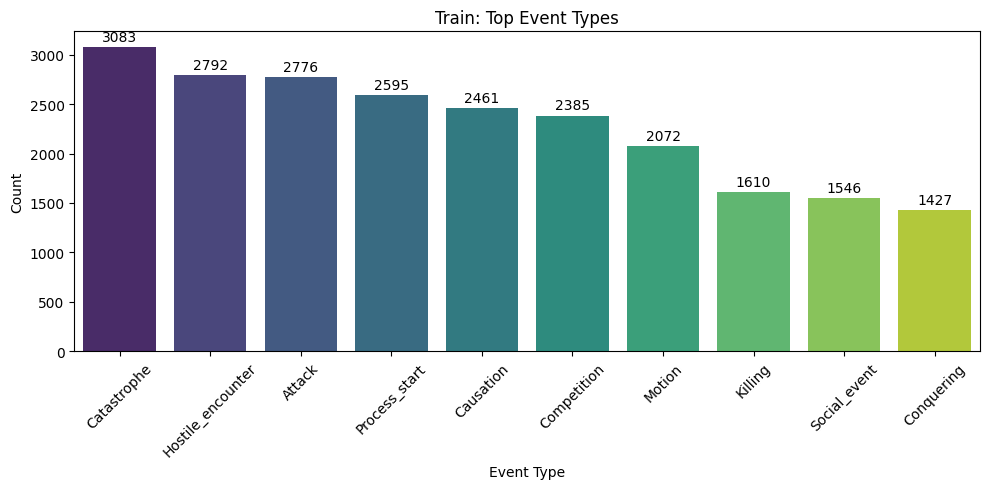

/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


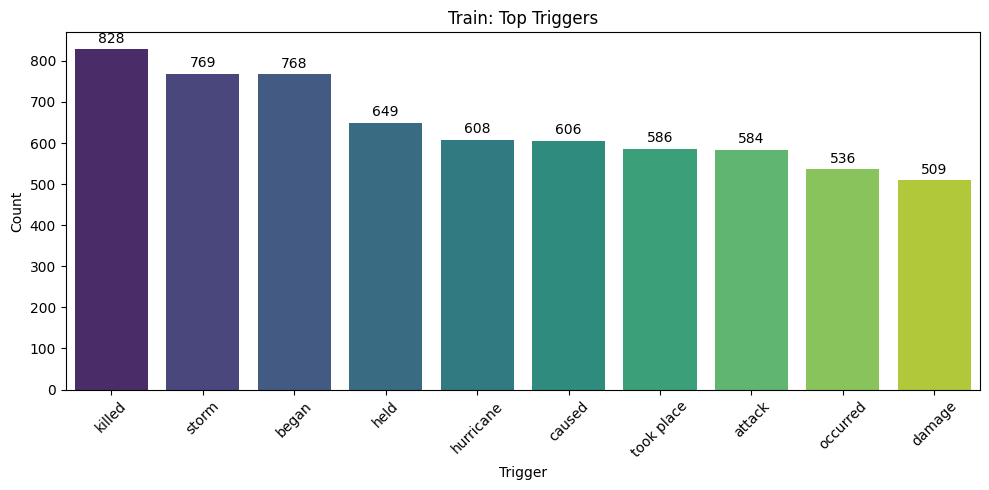

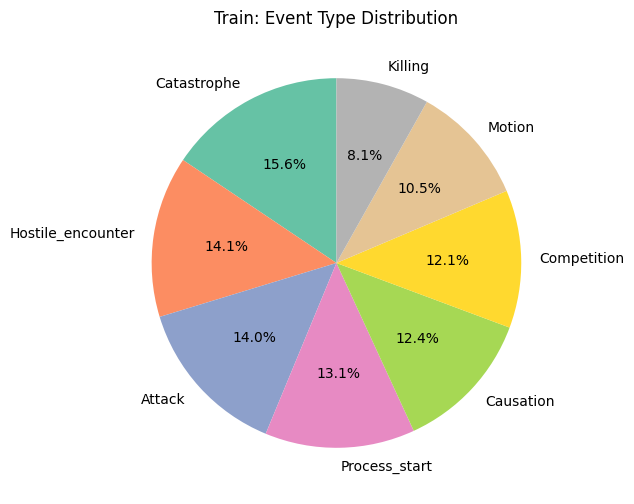

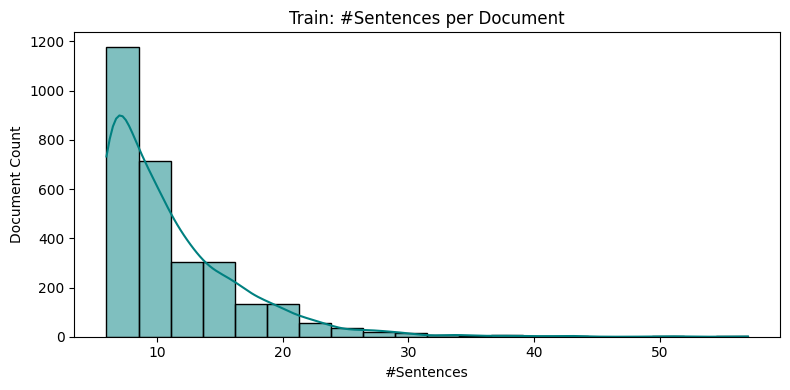

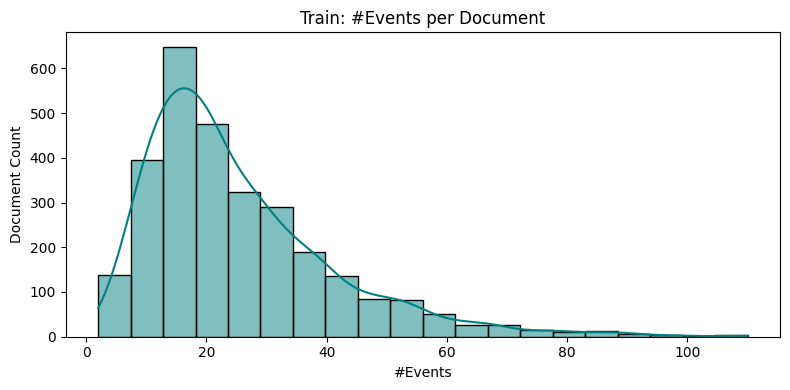


===== MAVEN-ERE STATISTICS (Valid) =====
Documents: 710
Sentences: 8042
Sentences per document (mean/min/max): {'mean': 11.326760563380281, 'min': 6, 'max': 75}
Total Events: 17780
Events per document (mean/min/max): {'mean': 25.04225352112676, 'min': 1, 'max': 123}
Events per sentence (mean/min/max): {'mean': 2.210892812733151, 'min': 0, 'max': 14}
Unique event types: 168
Most common event types: [('Catastrophe', 796), ('Hostile_encounter', 740), ('Competition', 686), ('Process_start', 637), ('Causation', 605), ('Attack', 604), ('Motion', 415), ('Killing', 405), ('Social_event', 405), ('Conquering', 320)]
Unique triggers: 3153
Most common triggers: [('killed', 176), ('storm', 172), ('began', 162), ('held', 157), ('hurricane', 151), ('took place', 146), ('caused', 138), ('became', 132), ('occurred', 130), ('attack', 117)]


/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


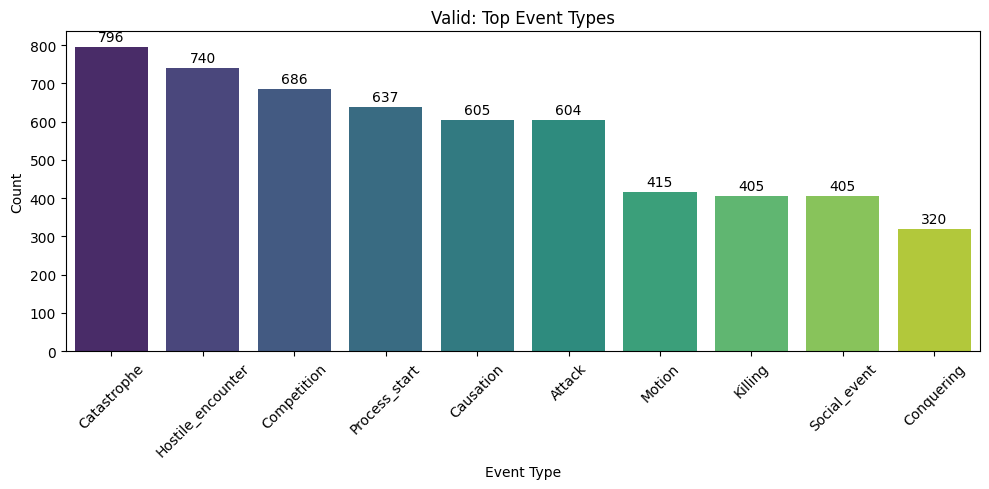

/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


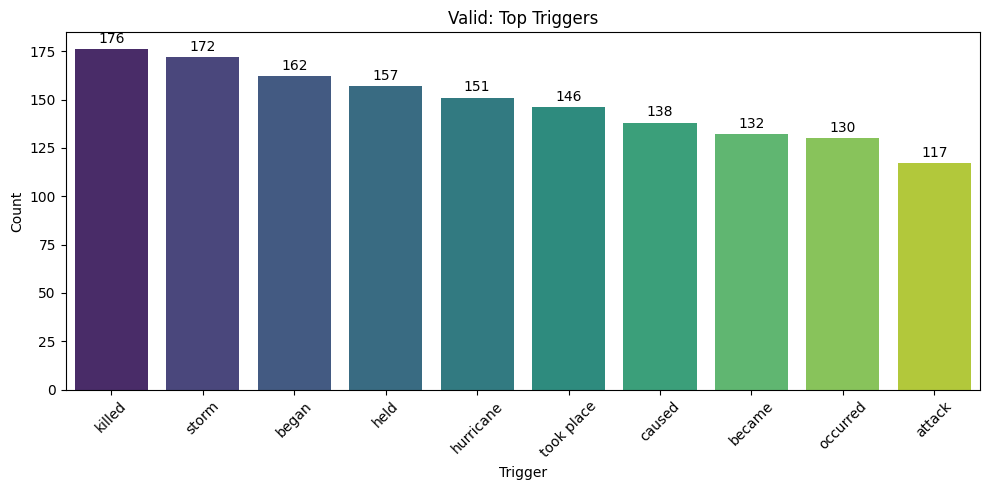

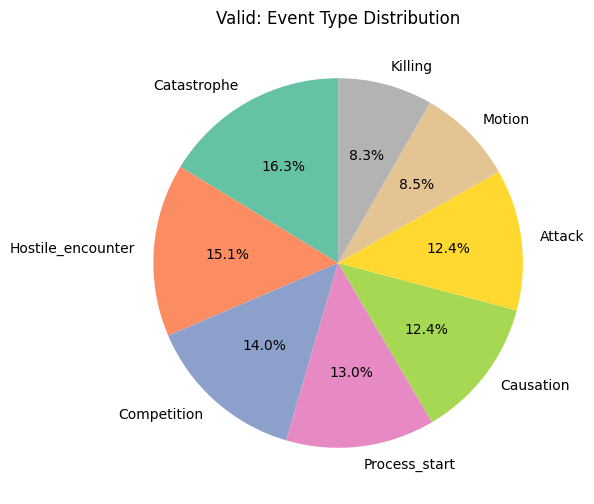

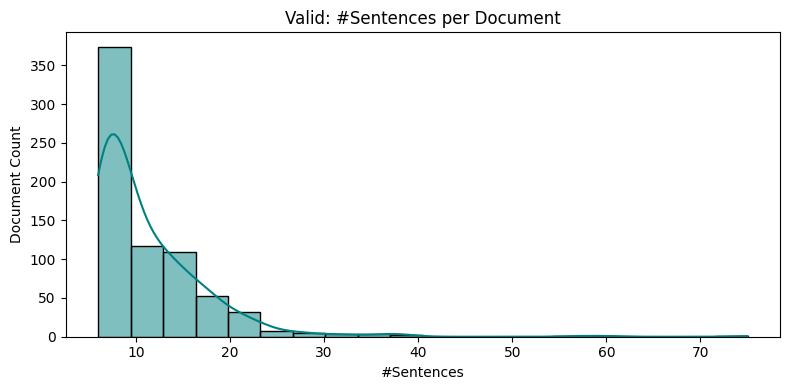

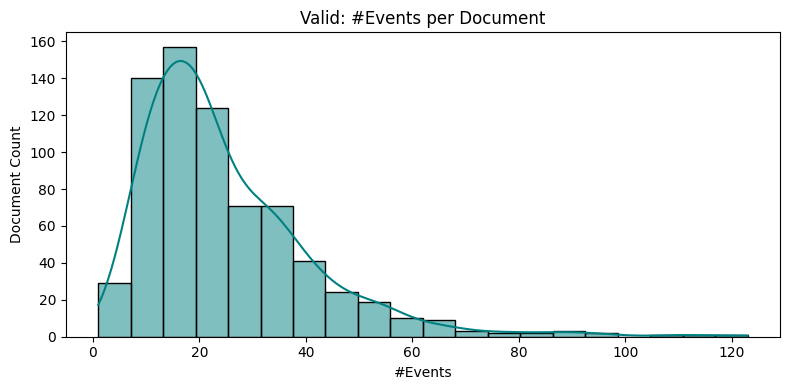


===== MAVEN-ERE STATISTICS (Test) =====
Documents: 857
Sentences: 9400
Sentences per document (mean/min/max): {'mean': 10.968494749124854, 'min': 6, 'max': 44}
Total Events: 41486
Events per document (mean/min/max): {'mean': 48.40840140023337, 'min': 11, 'max': 251}
Events per sentence (mean/min/max): {'mean': 4.413404255319149, 'min': 0, 'max': 29}
Unique event types: 168
Most common event types: [('Catastrophe', 1132), ('Process_start', 954), ('Attack', 946), ('Hostile_encounter', 899), ('Causation', 847), ('Motion', 716), ('Competition', 617), ('Killing', 616), ('Conquering', 536), ('Social_event', 513)]
Unique triggers: 10616
Most common triggers: [('storm', 333), ('killed', 246), ('began', 222), ('held', 217), ('caused', 209), ('tour', 196), ('hurricane', 189), ('took place', 186), ('occurred', 183), ('damage', 163)]


/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


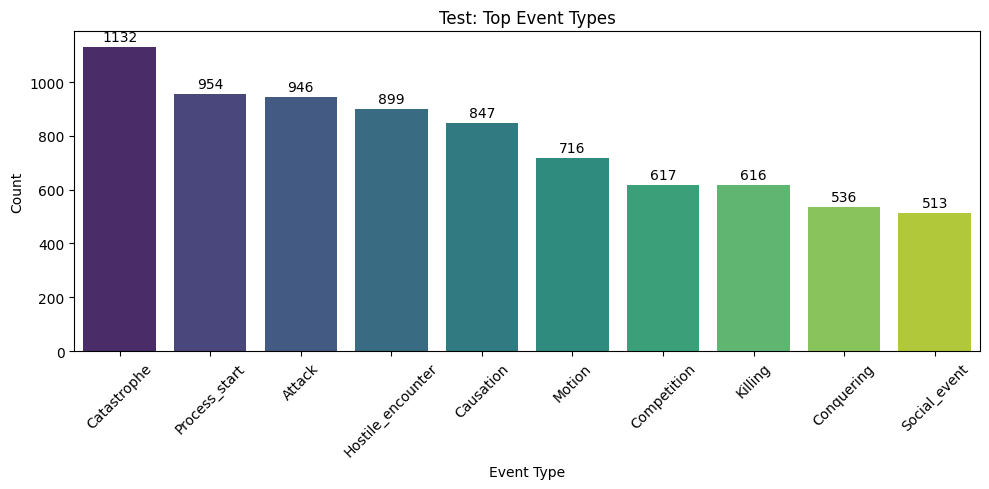

/tmp/ipython-input-1186361042.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(labels), y=list(values), palette='viridis')


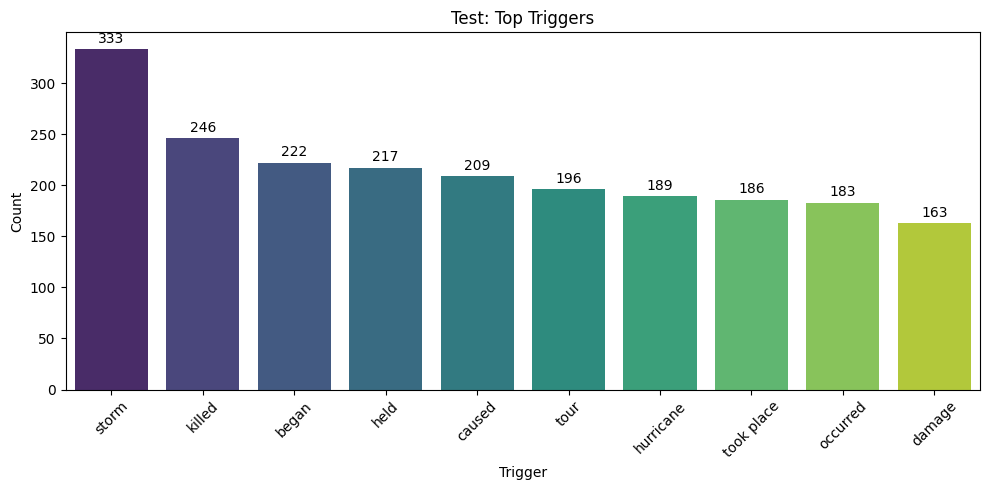

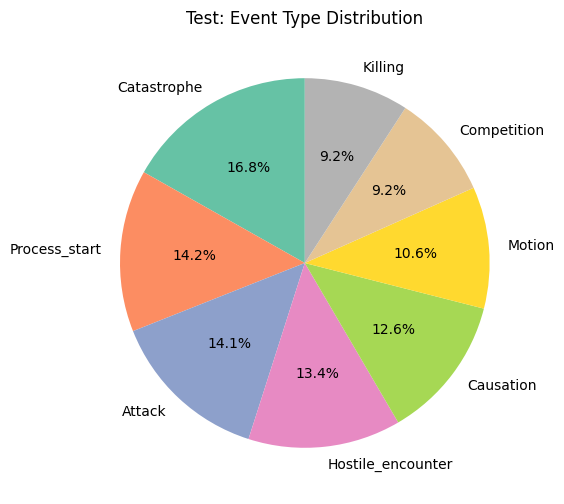

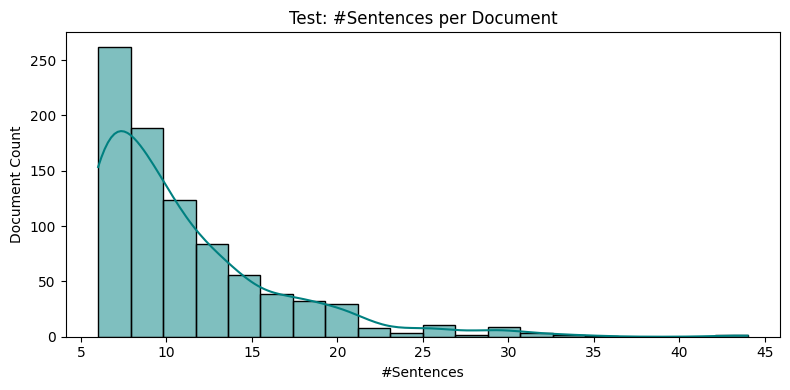

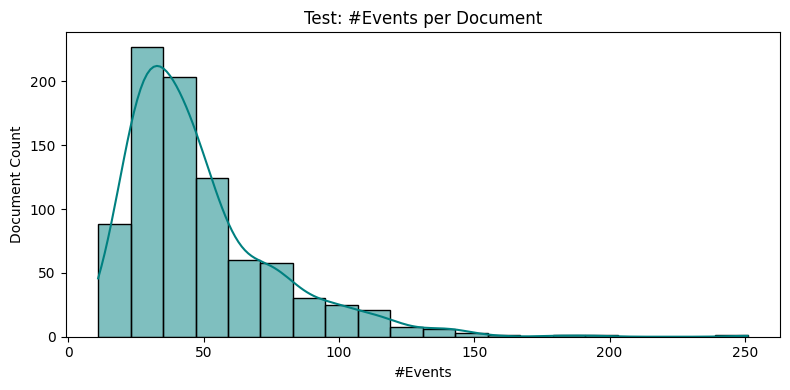

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def load_jsonl(filepath):
    records = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip():
                records.append(json.loads(line.strip()))
    return records

def extract_events_from_record(record):
    if 'events' in record and record['events']:
        return [
            {
                'type': ev['type'],
                'trigger_word': men['trigger_word'],
                'sent_id': men['sent_id']
            }
            for ev in record['events'] for men in ev.get('mention', [])
        ]
    elif 'event_mentions' in record and record['event_mentions']:
        return [
            {
                'type': em['type'],
                'trigger_word': em['trigger_word'],
                'sent_id': em['sent_id']
            }
            for em in record['event_mentions']
        ]
    else:
        return []

def mavenere_statistics(records):
    total_docs = len(records)
    total_sents = 0
    total_events = 0
    event_type_counter = Counter()
    trigger_counter = Counter()
    triggers_per_sent = []
    sentences_per_doc = []

    for record in records:
        sentences = record.get('sentences', [])
        events = extract_events_from_record(record)
        sentences_per_doc.append(len(sentences))
        total_sents += len(sentences)
        sent_triggers = [0] * len(sentences)
        for ev in events:
            event_type_counter[ev['type']] += 1
            trigger_counter[ev['trigger_word']] += 1
            sent_idx = ev['sent_id']
            if sent_idx < len(sent_triggers):
                sent_triggers[sent_idx] += 1
        triggers_per_sent.extend(sent_triggers)
        total_events += len(events)

    stats = {
        'num_documents': total_docs,
        'num_sentences': total_sents,
        'sentences_per_document': {
            'mean': sum(sentences_per_doc)/len(sentences_per_doc) if sentences_per_doc else 0,
            'min': min(sentences_per_doc) if sentences_per_doc else 0,
            'max': max(sentences_per_doc) if sentences_per_doc else 0,
        },
        'num_events': total_events,
        'events_per_document': {
            'mean': total_events / total_docs if total_docs else 0,
            'min': min([len(extract_events_from_record(r)) for r in records]) if records else 0,
            'max': max([len(extract_events_from_record(r)) for r in records]) if records else 0,
        },
        'events_per_sentence': {
            'mean': sum(triggers_per_sent)/len(triggers_per_sent) if triggers_per_sent else 0,
            'min': min(triggers_per_sent) if triggers_per_sent else 0,
            'max': max(triggers_per_sent) if triggers_per_sent else 0,
        },
        'num_unique_event_types': len(event_type_counter),
        'most_common_event_types': event_type_counter.most_common(10),
        'event_type_counter': event_type_counter,
        'num_unique_triggers': len(trigger_counter),
        'most_common_triggers': trigger_counter.most_common(10),
        'trigger_counter': trigger_counter,
        'sentences_per_doc': sentences_per_doc,
        'events_per_doc': [len(extract_events_from_record(r)) for r in records],
        'events_per_sent': triggers_per_sent,
    }
    return stats

def pretty_print_stats(stats, split_name=""):
    print(f"\n===== MAVEN-ERE STATISTICS ({split_name}) =====")
    print(f"Documents: {stats['num_documents']}")
    print(f"Sentences: {stats['num_sentences']}")
    print(f"Sentences per document (mean/min/max): {stats['sentences_per_document']}")
    print(f"Total Events: {stats['num_events']}")
    print(f"Events per document (mean/min/max): {stats['events_per_document']}")
    print(f"Events per sentence (mean/min/max): {stats['events_per_sentence']}")
    print(f"Unique event types: {stats['num_unique_event_types']}")
    print(f"Most common event types: {stats['most_common_event_types']}")
    print(f"Unique triggers: {stats['num_unique_triggers']}")
    print(f"Most common triggers: {stats['most_common_triggers']}")
    print("="*40)

def plot_bar(counter, title, xlabel, ylabel, topk=10):
    if not counter or sum(counter.values()) == 0:
        print(f"[Warning] No data to plot for: {title}")
        return
    items = counter.most_common(topk)
    labels, values = zip(*items)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(labels), y=list(values), palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    for i, v in enumerate(values):
        plt.text(i, v + max(values)*0.01, str(v), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_pie(counter, title, topk=8):
    if not counter or sum(counter.values()) == 0:
        print(f"[Warning] No data to plot for: {title}")
        return
    items = counter.most_common(topk)
    labels, values = zip(*items)
    plt.figure(figsize=(6, 6))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2', n_colors=len(labels)))
    plt.title(title)
    plt.show()

def plot_hist(data, title, xlabel, ylabel, bins=20):
    if not data or len(data) == 0:
        print(f"[Warning] No data to plot for: {title}")
        return
    plt.figure(figsize=(8, 4))
    sns.histplot(data, bins=bins, kde=True, color='teal')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

def plot_box(data, title, ylabel):
    if not data or len(data) == 0:
        print(f"[Warning] No data to plot for: {title}")
        return
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=data, color='orange')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    train_records = load_jsonl("/content/data/train.jsonl")
    valid_records = load_jsonl("/content/data/valid.jsonl")
    test_records  = load_jsonl("/content/data/test.jsonl")

    for split, records in [('Train', train_records), ('Valid', valid_records), ('Test', test_records)]:
        stats = mavenere_statistics(records)
        pretty_print_stats(stats, split)

        plot_bar(stats['event_type_counter'], f"{split}: Top Event Types", "Event Type", "Count", topk=10)
        plot_bar(stats['trigger_counter'], f"{split}: Top Triggers", "Trigger", "Count", topk=10)

        plot_pie(stats['event_type_counter'], f"{split}: Event Type Distribution", topk=8)

        plot_hist(stats['sentences_per_doc'], f"{split}: #Sentences per Document", "#Sentences", "Document Count")

        plot_hist(stats['events_per_doc'], f"{split}: #Events per Document", "#Events", "Document Count")

        #plot_box(stats['events_per_sent'], f"{split}: Event Distribution per Sentence", "Event Count per Sentence")


In [ ]:
import json

def collect_event_types(files, output_file="event_types.txt"):
    event_types = set()

    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line.strip())

                if "events" in data:
                    for event in data["events"]:
                        if "type" in event:
                            event_types.add(event["type"])

    with open(output_file, "w", encoding="utf-8") as out:
        for et in sorted(event_types):
            out.write(et + "\n")

    print(f"✅ {len(event_types)} unique event types saved in {output_file}")


if __name__ == "__main__":
    files = [
        "train.jsonl",
        "valid.jsonl",
        "test.jsonl"
    ]

    collect_event_types(files, "event_types.txt")

✅ 168 unique event types saved in event_types.txt
